This is a data challenge mini project on custormer churning for a ride-sharing app.  
It involves three parts:    

[ Part 1 - Exploratory data analysis](#Part-1---Exploratory-data-analysis): Include manipulating and visualizing time series data  

[ Part 2 ‑ Experiment and metrics design](#Part-2-‑-Experiment-and-metrics-design)

[ Part 3 ‑ Predictive modeling](#Part-3-‑-Predictive-modeling): Include data cleaning, exploratory analysis, visualization of rider data, building logistic regression and random forest models to predict important factors associated with customer retention, and final recommendations.

In [1]:
import pandas as pd
import numpy as np
import json 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler # scaling
from sklearn.utils import resample # upsampling
# For model evaluation
from sklearn.metrics import classification_report, roc_auc_score, f1_score

## Part 1 - Exploratory data analysis

In [68]:
# Import login data as pandas df
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.reset_index()
logins['count'] = 1
logins = logins.set_index('login_time')

In [6]:
#Aggregate these login counts based on 15 minute time intervals
logins_15min = logins.resample('15 min').sum()
logins_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


/Users/Sabrina/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


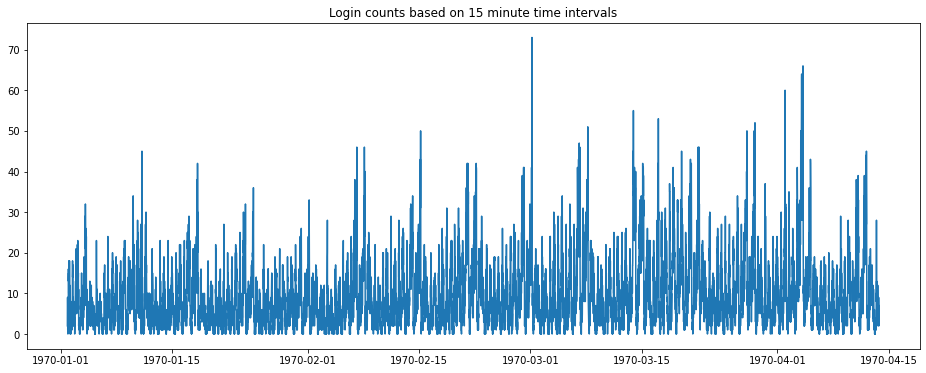

In [7]:
fig, ax = plt.subplots(figsize =(16,6))

ax = plt.plot(logins_15min)
plt.title('Login counts based on 15 minute time intervals')
plt.show()

In [8]:
# Get weekly count sums and dates
weeks = logins.resample('w').sum()
weeks.index

DatetimeIndex(['1970-01-04', '1970-01-11', '1970-01-18', '1970-01-25',
               '1970-02-01', '1970-02-08', '1970-02-15', '1970-02-22',
               '1970-03-01', '1970-03-08', '1970-03-15', '1970-03-22',
               '1970-03-29', '1970-04-05', '1970-04-12', '1970-04-19'],
              dtype='datetime64[ns]', name='login_time', freq='W-SUN')

Take a closer look at the data by plotting only one week:

In [9]:
# Plot 15 min interval counts during week 1 
week1 = logins_15min['1970-01-04':'1970-01-10']

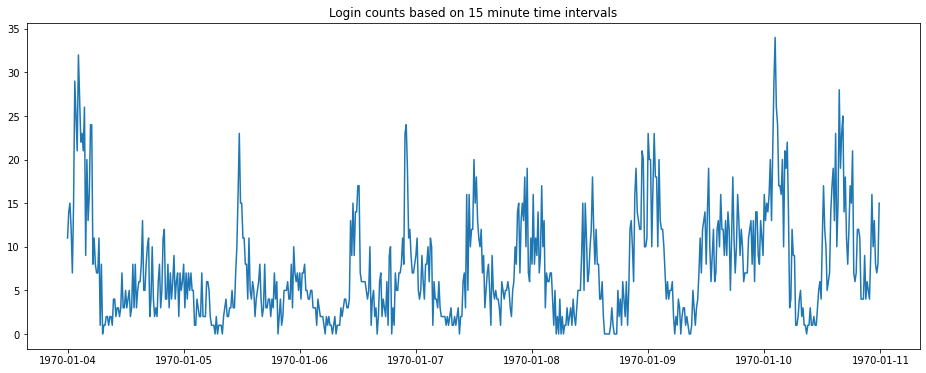

In [10]:
fig, ax = plt.subplots(figsize =(16,6))

ax = plt.plot(week1)
plt.title('Login counts based on 15 minute time intervals')
plt.show()

There seems to be daily cycles. Let's plot day-by-day throughout a week:

In [11]:
week1_dates = [i.isoformat() for i in np.unique(week1.index.date)]

In [12]:
week1.index[0]

Timestamp('1970-01-04 00:00:00', freq='15T')

In [13]:
week1_dates

['1970-01-04',
 '1970-01-05',
 '1970-01-06',
 '1970-01-07',
 '1970-01-08',
 '1970-01-09',
 '1970-01-10']

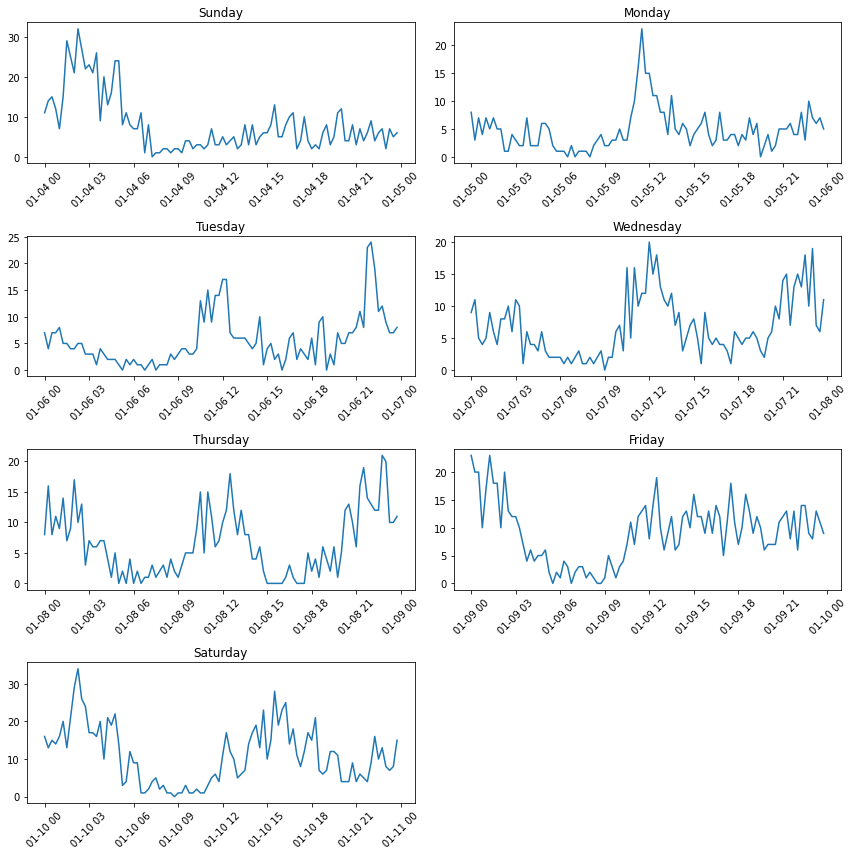

In [14]:
# Plot 15-min interval login time counts for 7 days throughout a week. 
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

plt.figure(figsize=(12,12))
for i,date in enumerate(np.unique(week1_dates)):
    plt.subplot(4,2,i+1)
    plt.plot(logins_15min[date])
    plt.xticks(rotation=45)
    plt.title(day_name[logins_15min[date].index.dayofweek[0]])
    #ax = fig.add_subplot(4,2,i+1)
    #ax.plot(logins_15min[date])
    #ax.tick_params(axis="x", labelsize=6)
plt.tight_layout()

Based on the plots above, it seems that the peak login time falls between 0-6 am from Friday to Sunday, while between 9am-3pm and/or 9pm-0am from Monday to Thursday. This could be because people use the service to commute to work during weekdays, while commute between bars or night clubs and home during weekend night.   
To validate this observation, we can calculate the daily peak login times and average those by day of the week.

### Feature extraction

In [15]:
dates = [i.isoformat() for i in logins_15min.index.date]
time = [i.isoformat() for i in logins_15min.index.time]
dayofweek = logins_15min.index.dayofweek.tolist()

In [16]:
df = logins_15min.reset_index()
df = pd.concat([df,pd.Series(dates),pd.Series(dayofweek), pd.Series(time)], axis=1)
df = df.rename(columns={0: 'date',1:'dayofweek', 2:'time'})
df.head()

,login_time,count,date,dayofweek,time
0,1970-01-01 20:00:00,2,1970-01-01,3,20:00:00
1,1970-01-01 20:15:00,6,1970-01-01,3,20:15:00
2,1970-01-01 20:30:00,9,1970-01-01,3,20:30:00
3,1970-01-01 20:45:00,7,1970-01-01,3,20:45:00
4,1970-01-01 21:00:00,1,1970-01-01,3,21:00:00


In [17]:
# Find timestamps when login count is maximum for each day
daily_max = []
for day in df['date'].unique():
    daily = df.loc[df['date']==day,:]
    time = daily.sort_values(by='count',ascending=False).iloc[0,:]
    daily_max.append(time)

daily_max = pd.DataFrame(daily_max)

daily_max = daily_max.set_index('login_time')
daily_max['daily_max_count']= 1
daily_max.head()

,count,date,dayofweek,time,daily_max_count
login_time,,,,,
1970-01-01 23:00:00,16,1970-01-01,3,23:00:00,1
1970-01-02 22:30:00,21,1970-01-02,4,22:30:00,1
1970-01-03 03:15:00,23,1970-01-03,5,03:15:00,1
1970-01-04 02:15:00,32,1970-01-04,6,02:15:00,1
1970-01-05 11:30:00,23,1970-01-05,0,11:30:00,1


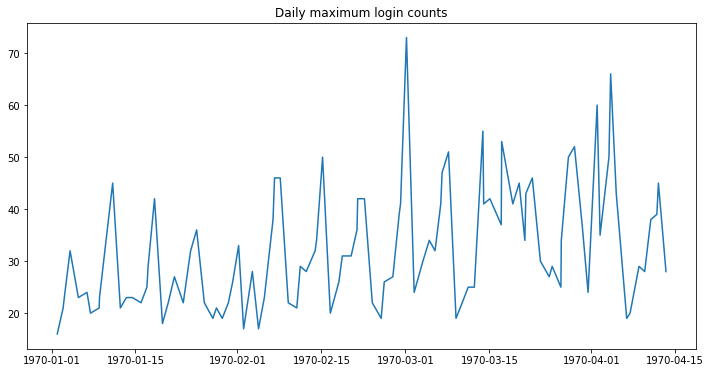

In [18]:
# Visualize changes in daily maximum login counts
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(daily_max['count'])
plt.title('Daily maximum login counts')
plt.show()

In [19]:
# Aggregate daily maximum login times by timestamps
daily_summary = daily_max.groupby(['dayofweek','time']).sum()
daily_summary = daily_summary.reset_index()
daily_summary.columns
daily_summary.head()

,dayofweek,time,count,daily_max_count
0,0,00:45:00,17,1
1,0,10:45:00,19,1
2,0,11:00:00,28,1
3,0,11:15:00,24,1
4,0,11:30:00,125,5


In [20]:
# Reorganize dataframe and aggregate by weekday (Mon-Thu) and weekend (Fri-Sun)
daily_max_count = daily_summary.pivot(columns='dayofweek',values='daily_max_count',index='time')
daily_max_count.fillna(0, inplace=True)

# Calculate week day and weekend sum of peak login times
daily_max_count['weekday'] = daily_max_count.iloc[:,1:5].sum(axis=1) 
daily_max_count['weekend'] = daily_max_count.iloc[:,[0,5,6]].sum(axis=1) 
daily_max_count.head()

dayofweek,0,1,2,3,4,5,6,weekday,weekend
time,,,,,,,,,
00:00:00,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
00:45:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
01:15:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
01:30:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
02:15:00,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0


In [21]:
# Set time to datetime index 
daily_max_count.index = pd.to_datetime(daily_max_count.index, format='%H:%M:%S')

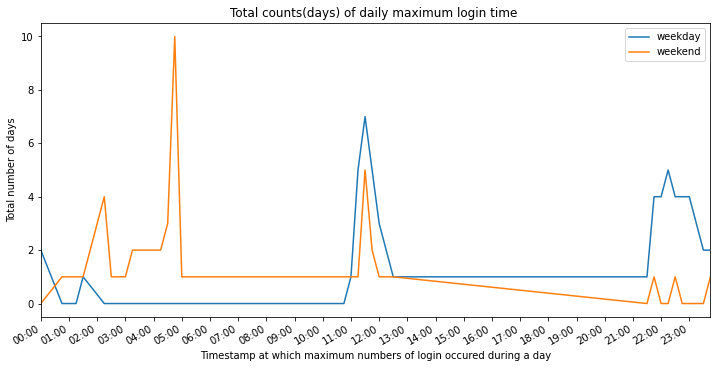

In [22]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(12,6))

daily_max_count['weekday'].plot(ax=ax)
daily_max_count['weekend'].plot(ax=ax)

# Define the date format
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
# Set x axis interval to one hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))


ax.legend()
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

plt.title('Total counts(days) of daily maximum login time ')
plt.xlabel('Timestamp at which maximum numbers of login occured during a day')
plt.ylabel('Total number of days')
plt.show()

Based on the above plot, during weekdays the peak time appears most frequently between 11:00-13:00 and 21:00-0:00,   
while during weekend the peak time appears mostly between 4:00-5:00 and secondarily between 1:30-2:30 and 11:00-12:00.

## Part 2 ‑ Experiment and metrics design

1. Metric to measure success of experiment:
   Over a peroid of experimental time, a significant increase in the total number (or percent change) of trips from UG (active at night) to UM (active during the day) during the day, and toll reimbursement from UM to UG during night time. Higher number indicate higher movement of drivers from lower-activity to higher-activity city. 

2. Experiment design  
    a . 
       -Randomly select 50% drivers who normally serve in one of the cities and offer reimbursement of toll (offer group), the rest drivers do not receive the offer (control group).  
       -Next, Meaure number of daily trips between both cities by all drivers over a week, separated by directions.
       - For each direction, calculate total number of inter-city trips conducted by two groups of drivers, repectively.   
       - Repeat the experiment at least 3 times (i.e.,continue for 3 more weeks). Calculate weekly percent change of total trips within each group. Increase replications (more weeks) as needed if only seen small increase in both groups per week. 
    b. By the end of the experiment, conduct **one way paired t-test** on total number (or percent change) of weekly trips between the two groups for both directions.   
    c. A significant result (i.e., increase in number of trips) will indicate effectiveness of the offer. That is, drivers who recieved the toll imbursement offer conducted more inter-city trips in the direction by which more drivers are needed.    
    
      Caveats: there will be a lot of variations in schedules and preferences among drivers, so randomly split drivers may not necessarily be the most effective way to measure the success of toll reimbursements offers. For example, some drivers may perfer short trips so the offer will not motivate them to drive to the other city. A more delicate design would involve split drivers by average number of inter-city trips they normally drive (high, medium, low number of inter-city trips), and compare effectiveness within each group. 

## Part 3 ‑ Predictive modeling

In [23]:
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
    records = pd.DataFrame(data)

In [24]:
records.shape

(50000, 12)

In [25]:
records.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### 1. Exploratory analysis

In [26]:
records['signup_date']= pd.to_datetime(records['signup_date'])
records['last_trip_date']= pd.to_datetime(records['last_trip_date'])

In [27]:
# Find the last date: 2014-07-01
lastdate = sorted(records['last_trip_date'])[-1]

# Find the earlies and latest sign up date
first_signup = records['signup_date'].min()
last_signup = records['signup_date'].max()
print('Last active date:',lastdate,
      '\nFirst sign-up date:', first_signup,
      '\nLast sign-up date:',last_signup)

Last active date: 2014-07-01 00:00:00 
First sign-up date: 2014-01-01 00:00:00 
Last sign-up date: 2014-01-31 00:00:00


In [28]:
# Calculate days since a customer's last ride, those with diff < 30 will be considered retained customer
from datetime import timedelta
records['diff'] = lastdate - records['last_trip_date']
records['active_days'] = records['last_trip_date'] - records['signup_date']
records['active_days'] = [int(i.days) for i in records['active_days']]

# We shall consider all customers with varies membership length (last_trip_date - signup_date),
# those that are active within the preceding 30 days of 2014-07-01 are considered 'active', 
# as indicated by '1' in the 'retained' column.
# Since the last sign up date is 2014-01-31, a '1' customer will be considered 'active after 6 months of sign up' by 2014-07-01. 

records['retained'] = records['diff'] < timedelta(days=30) 
records['retained'] = [int(i) for i in records['retained']] # convert boolean to 0, 1 
records.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,diff,active_days,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14 days,143,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57 days,96,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175 days,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2 days,170,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108 days,47,0


In [29]:
# Check for max and min of customer active time in days
print(records['active_days'].max(), records['active_days'].min())

181 0


In [30]:
pct_retained = records['retained'].mean()
print('Percent retained {}%:'.format(round(pct_retained*100,2))) # Total percent of customers retained.

Percent retained 36.62%:


In [31]:
# Check for missing data
records.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
diff                         0
active_days                  0
retained                     0
dtype: int64

In [32]:
# Identify outliers use IQR score
numeric = records[['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct',
                  'weekday_pct','avg_dist','avg_rating_by_driver', 'active_days']] # only check for numeric variables
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3-Q1
print(IQR)

trips_in_first_30_days      3.00
avg_rating_of_driver        0.70
avg_surge                   0.05
surge_pct                   8.60
weekday_pct                66.70
avg_dist                    4.52
avg_rating_by_driver        0.30
active_days               123.00
dtype: float64


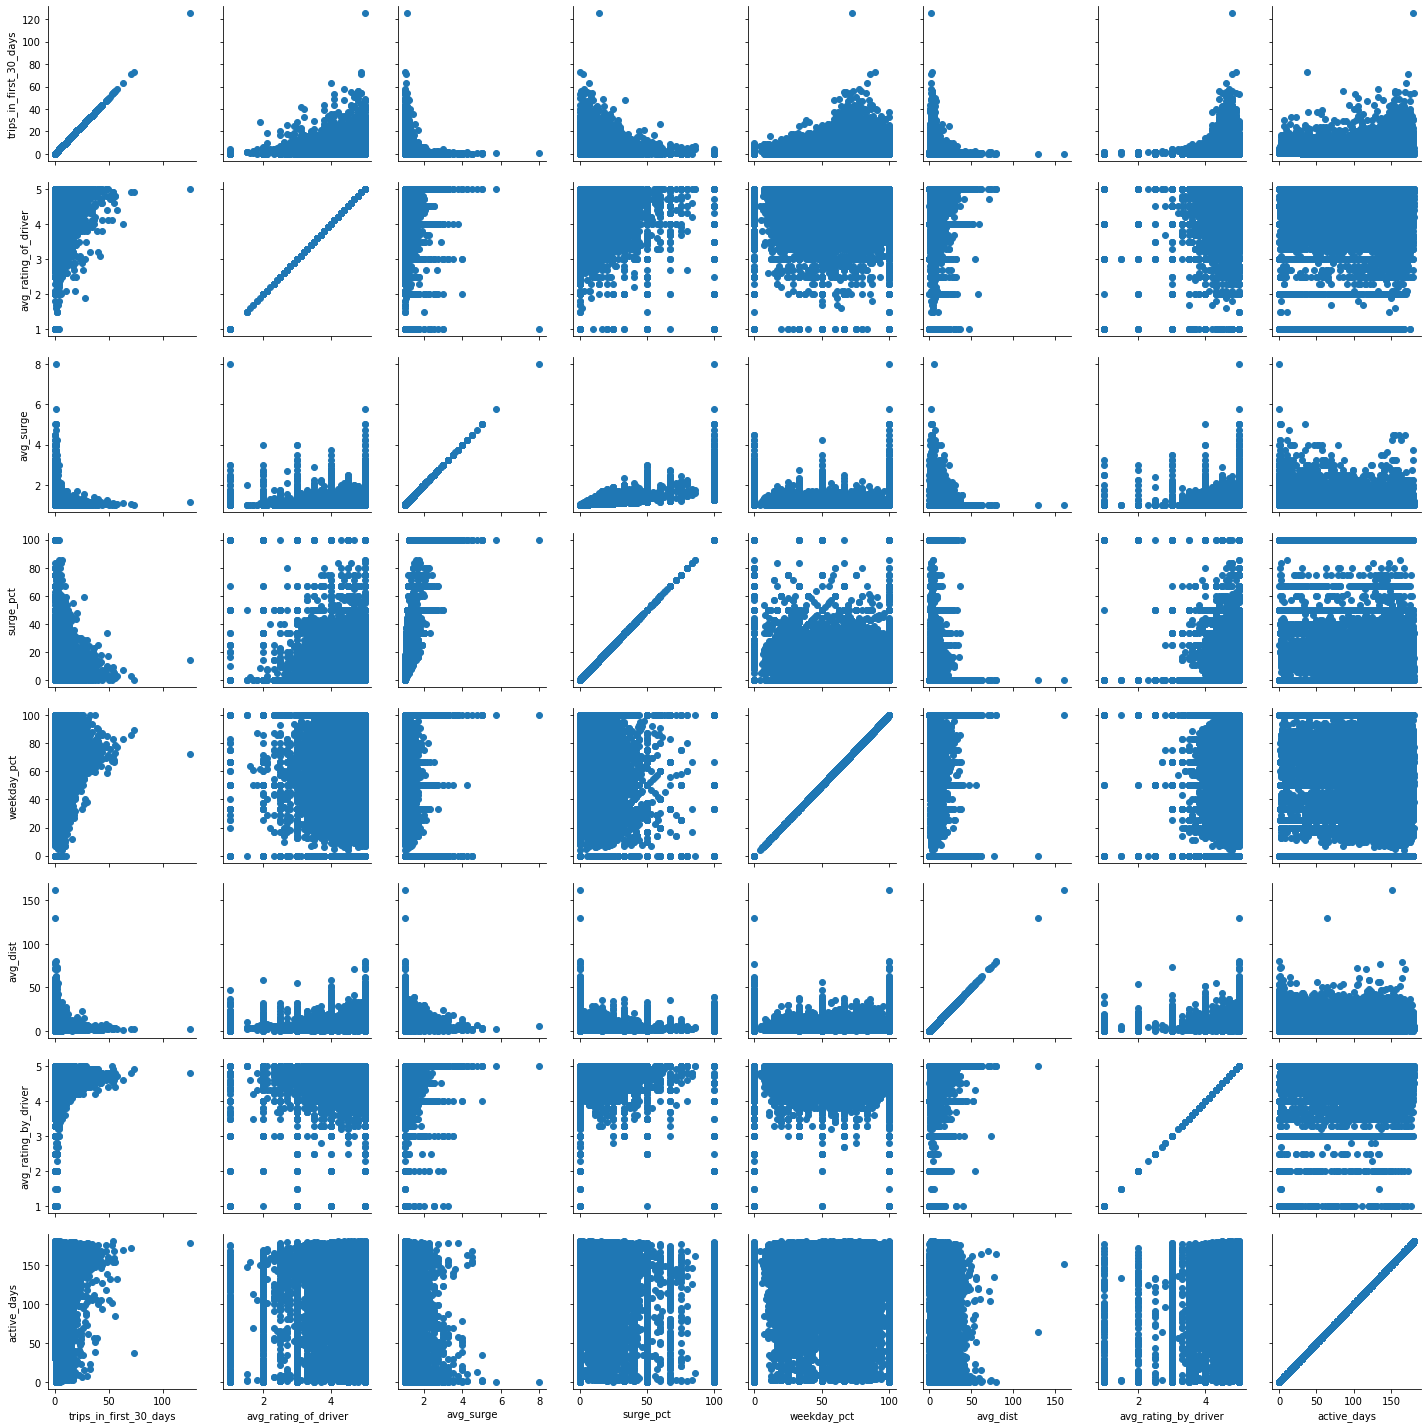

In [33]:
# Check for possible correlations among variables and outliers
g = sns.PairGrid(numeric)
g.map(plt.scatter)
plt.show() 
# Obvious outliers such as in trips_in_first_30_days and avg_pct
# No obvious correlations among variables

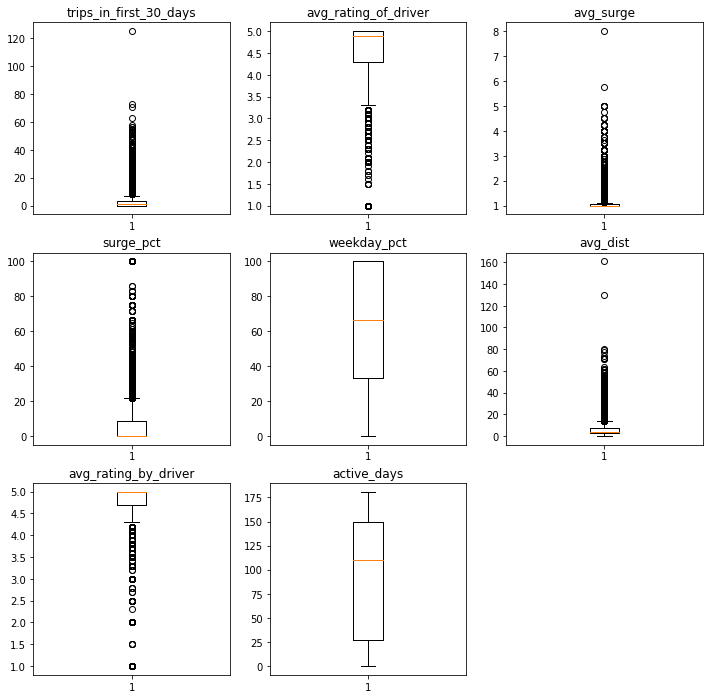

In [34]:
# Use box plot to take a closer look at outliers in each variable
plt.figure(figsize=(12,12))

for i,column in enumerate(numeric.columns):
    plt.subplot(3,3,i+1)
    plt.boxplot(numeric[column].dropna()) # drop null values
    plt.title(column)

plt.show()

In [35]:
# Remove outliers from the orginal dataframe
records_out = records[~((numeric < (Q1- 1.5*IQR)) | (numeric > (Q3 + 1.5*IQR))).any(axis=1)]

In [36]:
print(numeric.shape,records_out.shape)

(50000, 8) (30112, 15)


In [37]:
records_out.isnull().sum() # check for missing values again

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      5106
avg_surge                    0
last_trip_date               0
phone                      249
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       140
diff                         0
active_days                  0
retained                     0
dtype: int64

There are still rows with missing values after removing outliers. We shall decided what to do with those after we visualized the data.

Factors affecting customer retaining rate may include: 
 - 1) City (variable 'city') such as due to infrastracture, main industry and culture
 - 2) Afford to use high-end services ('ultimate_black_user', 'phone')
 - 3) Surge experenced (variables 'avg_surge' and'surge_pct'): people may be sensitive to price increase
 - 4) Purpose of use such as for commute during weekday (''weekday_pct')
 - 5) User experience and/or personality ('avg_rating_of_driver','avg_rating_by_driver')  
 
We can use visualization to examine the impact of these factors

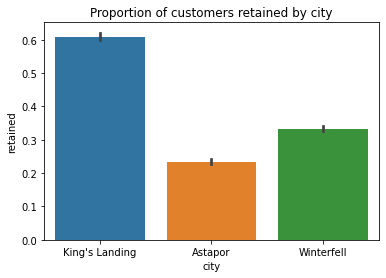

In [38]:
# 1) Impact of city
sns.barplot(x='city',y='retained', data=records_out)
plt.title('Proportion of customers retained by city')
plt.show()

Very significant impact by city. The ranking of customer retaining rate by city from high to low is: King's landing, Winterfell, Astapor.  

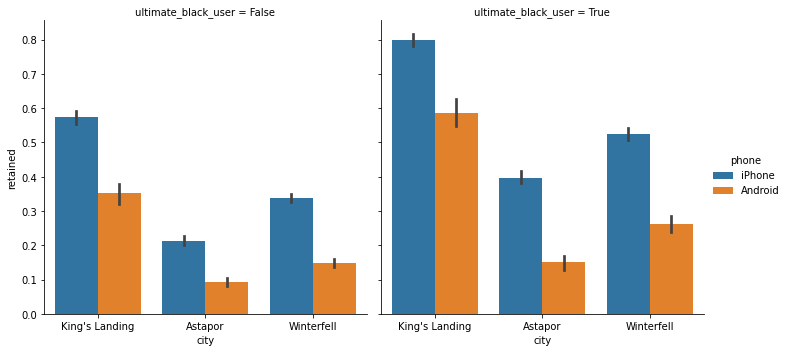

In [39]:
# 2) Impact of affordability on high-end services/devices
sns.catplot(x='city', y='retained', col='ultimate_black_user', hue='phone',kind='bar',data=records_out)
plt.show()

There is a significant higher retention in iPhone users than in Android users. Customers who use ultimate black are also more likly to stay.

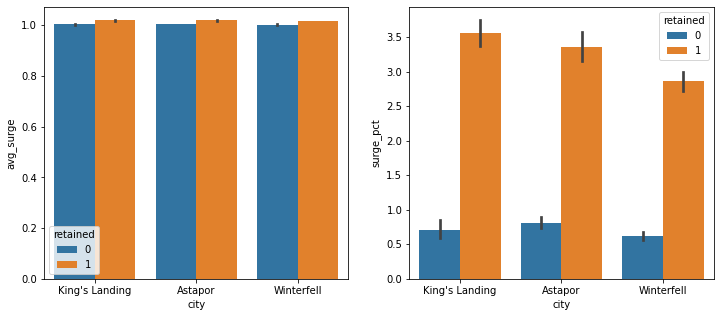

In [40]:
# 3) Surge experience
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.barplot(x='city', y='avg_surge', hue='retained', data=records_out, ax=axes[0])
sns.barplot(x='city', y='surge_pct', hue='retained', data=records_out, ax=axes[1])
plt.show()

Retained and non-retained customers did not experience much difference in average surge multiplier. 
However, the retained customers seen significant higher surge_pct in all three cities

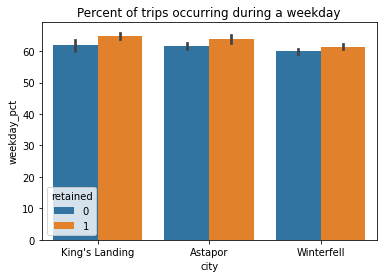

In [41]:
# 4) Purpose of use such as for commute during weekday (''weekday_pct')

sns.barplot(x='city', y='weekday_pct', hue='retained', data=records_out)
plt.title('Percent of trips occurring during a weekday')
plt.show()

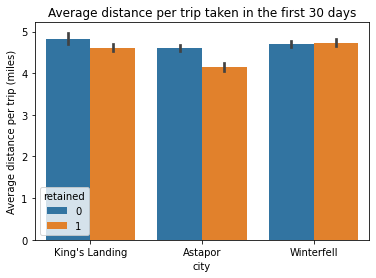

In [42]:
sns.barplot(x='city', y='avg_dist', hue='retained', data=records_out)
plt.title('Average distance per trip taken in the first 30 days')
plt.ylabel('Average distance per trip (miles)')
plt.show()

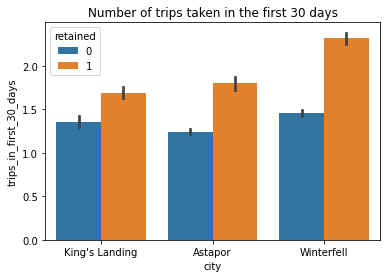

In [43]:
sns.barplot(x='city', y='trips_in_first_30_days', hue='retained', data=records_out)
plt.title('Number of trips taken in the first 30 days')
plt.show()

'weekday_pct' may have a little impact on retention, which is slightly higher in retained customers.   
On the other hand, retained customers ride for significantly smaller distance per trip in Astapor, and took more trips during the first 30 days in all three cities.

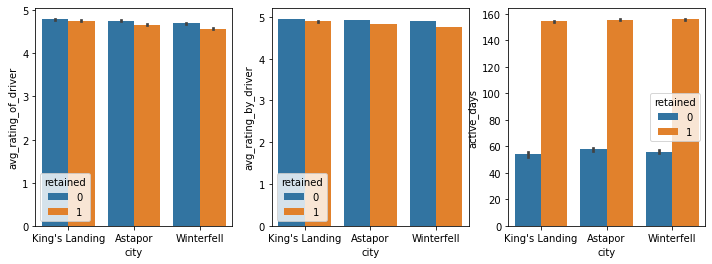

In [44]:
# 5) User experience and/or personality ('avg_rating_of_driver','avg_rating_by_driver', 'active_days') 
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.barplot(x='city', y='avg_rating_of_driver', hue='retained', data=records_out, ax=axes[0])
sns.barplot(x='city', y='avg_rating_by_driver', hue='retained', data=records_out, ax=axes[1])
sns.barplot(x='city', y='active_days', hue='retained', data=records_out, ax=axes[2])
plt.show()

Ratings (bot by or of driver) do not seem to have very significant effects on retention. Therefore, we shall drop the variables 'avg_rating_of_driver' and 'avg_rating_by_driver' which contain many missing values. Rows with missing values in 'phone' will be droped.  
However, customers retained on average have more than double the length in active days.

In [45]:
records_cleaned = records_out.drop(columns=['avg_rating_of_driver','avg_rating_by_driver']).dropna()
print(records_cleaned.shape)

(29863, 13)


In [46]:
records_cleaned.isnull().sum().sum() # All missing values were dealt with 

0

**To summarize**, the most important factors affection retention appear to be:  
- city, 
- phone and use of ultimate black service,
- average distance per trip, number of trips taken during first 30 days after signup.
- the percent of trips taken with surge multiplier > 1   
In addition, an important trait in retained customer is that they have much longer active days (days between first sign up and last trip).

### 2. Build a model to predict customer retention

#### 1) Firstly, we can build a logistic regression model to predict if a customer will be retained or not given the variables in original dataframe. 
This is a baseline model and also help us understand what features may be important.
Using linear regression model to predict number of active days were considered, but discarded since we do not see obvious linear correlations between 'active_days' and other variables 

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [48]:
# Upsampling class 1 (retained) to balance with classes 0 :
records_retained = resample(records_cleaned[records_cleaned.retained == 1], replace=True, n_samples = records_cleaned['retained'].value_counts()[0])
records_upsampled = pd.concat([records_cleaned[records_cleaned.retained == 0],records_retained])
y = records_upsampled.retained
records_upsampled.shape
    

(38538, 13)

In [49]:
X = pd.get_dummies(records_cleaned, columns=['city','phone','ultimate_black_user']).drop(
    columns=['signup_date','last_trip_date','diff','active_days',
            'retained'])
# drop columns 'signup_date','last_trip_date','diff' because they are not likely to affect retaining rate.
# 'active_days' is dropped because it is highly correlated with 'retained'

In [50]:
y = records_cleaned.retained

In [51]:
# Conduct cross validation and Tuning model parameter C
# Build model with best C

import warnings
warnings.filterwarnings('ignore')

def logistic_model(X, y):

    # Upsampling class 1 (retained) to balance with classes 0 :
    X_retained_upsample = resample(X[y == 1], replace=True, n_samples = X[y == 0].shape[0])
    X_resampled = pd.concat([X[y==0], X_retained_upsample])
    # Update y labels
    y_resampled = pd.Series([0]*X[y==0].shape[0] + [1]*X_retained_upsample.shape[0])

    
    # scale and split data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled.values)
    
    xtrain,xtest,ytrain,ytest = train_test_split(X_scaled,y_resampled.values,test_size=0.3,random_state=5)
    
    # Create classifier instance
    clf= LogisticRegression(max_iter =1000)
    
    # GridsearchCV
    Cs = [0.01, 0.1, 1, 10,100] # values to search
    model = GridSearchCV(clf, param_grid={'C':Cs}, scoring='roc_auc')
    model.fit(xtrain,ytrain)
    best_C = model.best_params_['C']
    best_score = model.best_score_
    
    # Train model with best C
    clf = LogisticRegression(C=best_C)
    clf.fit(xtrain,ytrain)
    
    # Evaluate models
    train_auroc = round(roc_auc_score(ytrain,clf.predict_proba(xtrain)[:,1]),3)
    test_auroc = round(roc_auc_score(ytest,clf.predict_proba(xtest)[:,1]),3)
    
    print('Best C:',best_C)
    print('AUROC for training data:',train_auroc)
    print('AUROC for testing data:',test_auroc)
    print('Classification report for test data:\n',
          classification_report(clf.predict(xtest),ytest, 
                                target_names=['Not retained','Retained']))

    
    # Get scaled coefficients which indicate the importance of features
    coefs = clf.coef_.flatten()
    features = pd.DataFrame({'features':X.columns.tolist(),'coefs':coefs}).sort_values(by=['coefs'],
                                                                                ascending=False)
    features = features.set_index('features')

    return features, train_auroc, test_auroc
    

In [52]:
lm_all = logistic_model(X,y)
lm_all[0].sort_values(by='coefs', ascending=False)

Best C: 0.1
AUROC for training data: 0.776
AUROC for testing data: 0.787
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.78      0.69      0.73      6461
    Retained       0.66      0.75      0.70      5101

    accuracy                           0.72     11562
   macro avg       0.72      0.72      0.72     11562
weighted avg       0.72      0.72      0.72     11562



,coefs
features,
avg_surge,0.568136
city_King's Landing,0.427943
phone_iPhone,0.217900
trips_in_first_30_days,0.206519
ultimate_black_user_True,0.186245
surge_pct,0.116952
weekday_pct,0.060315
avg_dist,-0.016765
city_Winterfell,-0.051439


**Summary**: Based on the logistic regression model, important variables that are predictive of retention include avg_surge, signed up in the city King's landing, and being an iPhone user.   
On the other hand, factors associated with no retention include use a Android phone, not use ultimate black, and being in Astapor.  
Because city has a big effect on retention rate, we should examine factors within each city one by one, which can lead to customized strategy for each city and for spececific predictive models

In [53]:
# Subset data by cities
kings_landing = X.loc[X.iloc[:,6]==1,:]
y_kings = records_cleaned.loc[kings_landing.index,'retained']

astapor = X.loc[X.iloc[:,5]==1,:]
y_astapor = records_cleaned.loc[astapor.index,'retained']

winterfell = X.loc[((X.iloc[:,5]==0) & (X.iloc[:,6]==0)),:]
y_winterfell = records_cleaned.loc[winterfell.index,'retained']

In [54]:
# Check feature importance by cities. 
# Note the city columns in the output should be ignored because the values are same (0 or 1) in each column
# King's landing
lm_kings, kings_train_auroc, kings_test_auroc = logistic_model(kings_landing,y_kings)

Best C: 100
AUROC for training data: 0.724
AUROC for testing data: 0.739
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.79      0.66      0.72       852
    Retained       0.58      0.73      0.65       549

    accuracy                           0.69      1401
   macro avg       0.69      0.69      0.68      1401
weighted avg       0.71      0.69      0.69      1401



In [55]:
# Astapor
lm_astapor, astapor_train_auroc, astapor_test_auroc = logistic_model(astapor, y_astapor)

Best C: 0.1
AUROC for training data: 0.744
AUROC for testing data: 0.734
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.72      0.67      0.69      2530
    Retained       0.64      0.69      0.66      2146

    accuracy                           0.68      4676
   macro avg       0.68      0.68      0.68      4676
weighted avg       0.68      0.68      0.68      4676



In [56]:
# Winterfell
lm_winterfel, winterfel_train_auroc, winterfel_test_auroc = logistic_model(winterfell, y_winterfell)

Best C: 0.01
AUROC for training data: 0.745
AUROC for testing data: 0.754
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.74      0.67      0.70      3008
    Retained       0.64      0.72      0.68      2478

    accuracy                           0.69      5486
   macro avg       0.69      0.69      0.69      5486
weighted avg       0.70      0.69      0.69      5486



In [57]:
# Combine parameters
importance = pd.concat([lm_kings, lm_astapor, lm_winterfel], axis=1).reset_index()
importance.columns = ['features','kings landing','astapor','winterfell']
importance = importance.sort_values(by='kings landing', ascending=False)
lm_importance = importance.drop([2,3,4])

In [58]:
lm_importance

,features,kings landing,astapor,winterfell
1,avg_surge,0.767907,0.521509,0.452978
10,ultimate_black_user_True,0.241349,0.203109,0.169141
6,phone_iPhone,0.171948,0.252945,0.236709
11,weekday_pct,0.043819,0.062412,0.070529
0,avg_dist,0.005570,-0.109707,0.055682
7,surge_pct,0.005481,0.139818,0.173030
8,trips_in_first_30_days,-0.040729,0.130058,0.335803
5,phone_Android,-0.171948,-0.252945,-0.236709
9,ultimate_black_user_False,-0.241349,-0.203109,-0.169141


#### 2) Next, let's consider a random forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
# Modify function to fit random forest classifier
def rf_model(X,y):
    '''Function to build a random forest classifier, find best parameters via gridsearch,
    and return the ranked importance of parameters
    '''
    xtrain,xtest,ytrain,ytest = train_test_split(X.values,y.values,test_size=0.3,random_state=5)
    
    # GridsearchCV
    max_depth = [6,7,8]
    min_samples_split = [100, 200, 400]
    min_samples_leaf = [10, 25, 50]
    params = {'max_depth':max_depth,
                'min_samples_split':min_samples_split,
                'min_samples_leaf':min_samples_leaf,}
    
    rf = RandomForestClassifier()
    model = GridSearchCV(rf, param_grid=params, scoring='roc_auc')
    model.fit(xtrain,ytrain)
    best_params = model.best_params_
    print('Best parameters:',best_params)
    
    # Train a classifier with best estimates
    rf= RandomForestClassifier(max_depth = best_params['max_depth'],
                               min_samples_split = best_params['min_samples_split'],
                              min_samples_leaf = best_params['min_samples_leaf'])
    rf.fit(xtrain,ytrain)
    
    # Model evaluation
    train_auroc = round(roc_auc_score(ytrain,rf.predict_proba(xtrain)[:,1]),3)
    test_auroc = round(roc_auc_score(ytest,rf.predict_proba(xtest)[:,1]),3)
    print('AUROC for training data:',train_auroc)
    print('AUROC for testing data:',test_auroc)
    print('Classification report for test data:\n',
          classification_report(rf.predict(xtest),ytest, 
                                target_names=['Not retained','Retained']))
    
    # Get scaled coefficients which indicate the importance of features
    importance = pd.DataFrame({'VarCode': X.columns, 
                               'Importance': rf.feature_importances_}).sort_values(by=['Importance'],
                                                                                ascending=False)
    importance = importance.set_index('VarCode')
    return importance, train_auroc, test_auroc

In [61]:
# Use all cities' data
rf_all, all_train_auroc, all_test_auroc = rf_model(X,y)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 25, 'min_samples_split': 100}
AUROC for training data: 0.84
AUROC for testing data: 0.834
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.89      0.78      0.83      6512
    Retained       0.57      0.75      0.64      2447

    accuracy                           0.77      8959
   macro avg       0.73      0.77      0.74      8959
weighted avg       0.80      0.77      0.78      8959



In [62]:
# Modeling by individual cities 
rf_kingslanding, rf_kings_train_auroc, rf_kings_test_auroc = rf_model(kings_landing,y_kings)
rf_astapor, rf_astapor_train_auroc, rf_astapor_test_auroc = rf_model(astapor, y_astapor)
rf_winterfell, rf_winterfell_train_auroc, rf_winterfell_test_auroc = rf_model(winterfell, y_winterfell)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 25, 'min_samples_split': 100}
AUROC for training data: 0.809
AUROC for testing data: 0.774
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.55      0.67      0.60       562
    Retained       0.83      0.75      0.79      1232

    accuracy                           0.72      1794
   macro avg       0.69      0.71      0.69      1794
weighted avg       0.74      0.72      0.73      1794

Best parameters: {'max_depth': 8, 'min_samples_leaf': 25, 'min_samples_split': 100}
AUROC for training data: 0.828
AUROC for testing data: 0.812
Classification report for test data:
               precision    recall  f1-score   support

Not retained       0.96      0.83      0.89      2729
    Retained       0.33      0.71      0.45       325

    accuracy                           0.82      3054
   macro avg       0.65      0.77      0.67      3054
weighted avg       0.89      0.82  

In [63]:
importance = pd.concat([rf_kingslanding,rf_astapor,rf_winterfell], axis=1).reset_index()
importance.columns = ['features','kings landing', 'astapor','winterfell']
importance = importance.sort_values(by='kings landing', ascending=False)

importance = importance.drop([2,3,4]) # drop the rows for cities which has same values and not contribute to the model
importance

,features,kings landing,astapor,winterfell
7,surge_pct,0.197966,0.269560,0.208082
11,weekday_pct,0.184276,0.196193,0.260675
1,avg_surge,0.145643,0.180618,0.185717
10,ultimate_black_user_True,0.112262,0.048324,0.040505
8,trips_in_first_30_days,0.082665,0.052985,0.078194
9,ultimate_black_user_False,0.079245,0.051080,0.036054
0,avg_dist,0.074483,0.087636,0.066790
5,phone_Android,0.064579,0.050794,0.055483
6,phone_iPhone,0.058883,0.062808,0.068499


**Summary**: Based on random forest models for each city, the top features include surge_pct, weekday_pct and avg_surge. These results largely agree with that from logistic regression, but the latter places more importance in ultimate black user and iPhone user.  

In [64]:
# Combine feature importance of both logistic and rf models into one dataframe
summary = pd.concat([lm_importance.set_index('features'),importance.set_index('features')], axis=1)
summary.columns = ['lm_kings landing','lm_astapor','lm_winterfell','rf_kings landing','rf_astapor','rf_winterfell']
summary =summary.sort_values(by='lm_kings landing', ascending=False)

# Combine accuracy scores into one dataframe
auroc = pd.DataFrame({'lm_kings': [kings_train_auroc,kings_test_auroc],
              'rf_kings':[rf_kings_train_auroc, rf_kings_test_auroc],
             'lm_astapor': [astapor_train_auroc, astapor_test_auroc],
              'rf_astapor': [rf_astapor_train_auroc, rf_astapor_test_auroc],
             'lm_winterfell': [winterfel_train_auroc, winterfel_test_auroc],
              'rf_winterfell': [rf_winterfell_train_auroc, rf_winterfell_test_auroc]
             }, index=['Training AUROC', 'Testing AUROC'])


In [65]:
summary # Summary of feature importance 

,lm_kings landing,lm_astapor,lm_winterfell,rf_kings landing,rf_astapor,rf_winterfell
avg_surge,0.767907,0.521509,0.452978,0.145643,0.180618,0.185717
ultimate_black_user_True,0.241349,0.203109,0.169141,0.112262,0.048324,0.040505
phone_iPhone,0.171948,0.252945,0.236709,0.058883,0.062808,0.068499
weekday_pct,0.043819,0.062412,0.070529,0.184276,0.196193,0.260675
avg_dist,0.005570,-0.109707,0.055682,0.074483,0.087636,0.066790
surge_pct,0.005481,0.139818,0.173030,0.197966,0.269560,0.208082
trips_in_first_30_days,-0.040729,0.130058,0.335803,0.082665,0.052985,0.078194
phone_Android,-0.171948,-0.252945,-0.236709,0.064579,0.050794,0.055483
ultimate_black_user_False,-0.241349,-0.203109,-0.169141,0.079245,0.051080,0.036054


In [66]:
auroc # Summary of model accuracy by area under ROC

,lm_kings,rf_kings,lm_astapor,rf_astapor,lm_winterfell,rf_winterfell
Training AUROC,0.724,0.809,0.744,0.828,0.745,0.837
Testing AUROC,0.739,0.774,0.734,0.812,0.754,0.824


### 3. Recommendations

Although random forest classifiers generally resulted in higher accuracy than logistic regressions, they are not significantly better than the latter but less interpretable. Therefore, we will focus on the logistic regression results. 

- Both models indicated that cities play an important role in customer retention, thus we need to have targeted strategies for each city in order to improve customer retaining rate.

- For King's landing, the top feature is related to the number of surge multiplier a customer experienced. This indicate that a high demand in the service may contribute to the higher retention rate in this city, so does higher demand for premium service ultimate black (as indicated by the 3rd ranked feature). Therefore, attracting more drivers, expand and offer promotions to the ultimate black service may improve customer experience and lead to higher retention.

- For Astapor, surge is also the top positive predictor, indicating higher demand as well. However, being an iPhone user (2nd most important) is more likely to stay than being an Android user. This may be because iPhone users are less sensitive to price than Android users (assuming iPhone is more expensive than average price of an Android phone). Therefore, offer exclusive promotions to Android phone users may help to increase retention, in addition to expand service availability for better experience and less cost (from surge multiplier) for the customers in Astapor. 

- For Winterfell, trips taken during the first 30 days was an important factor, in addition to surge and phone. The underlying reason for this is unclear based on the data set we have. A possibility is that there is another competitor which offers more lucrative pricing, and customers initially signed up for both services and immediately discarded the one that has higher pricing. Heavy promotions applied during the first 30 days after sign up may help to improve customer retention in Winterfell.
